In [1]:
import os
import atexit
import sys
import pyspark
from pyspark.context import SparkContext
from pyspark.sql import SQLContext
import findspark
from sparkhpc import sparkjob
import pandas
from pyspark.sql import SparkSession

#Exit handler to clean up the Spark cluster if the script exits or crashes
def exitHandler(sj,sc):
    try:
        print('Trapped Exit cleaning up Spark Context')
        sc.stop()
    except:
        pass
    try:
        print('Trapped Exit cleaning up Spark Job')
        sj.stop()
    except:
        pass

findspark.init()

#Parameters for the Spark cluster
nodes=3
tasks_per_node=8 
memory_per_task=1024 #1 gig per process, adjust accordingly
# Please estimate walltime carefully to keep unused Spark clusters from sitting 
# idle so that others may use the resources.
walltime="3:00" #60 min 
os.environ['SBATCH_PARTITION']='lattice' #Set the appropriate ARC partition

sj = sparkjob.sparkjob(
     ncores=nodes*tasks_per_node,
     cores_per_executor=tasks_per_node,
     memory_per_core=memory_per_task,
     walltime=walltime
    )

try:
    print('Cleaning up Spark Job')
    sj.stop()
except:
    pass

sj.wait_to_start()

try:
    print('Cleaning up Spark Context')
    sc.stop()
except:
    pass

sc = sj.start_spark()

#Register the exit handler                                                                                                     
atexit.register(exitHandler,sj,sc)

#You need this line if you want to use SparkSQL
sqlCtx=SQLContext(sc)
print("RUNNING")

INFO:sparkhpc.sparkjob:Submitted batch job 636839



Cleaning up Spark Job


INFO:sparkhpc.sparkjob:Submitted cluster 0


Cleaning up Spark Context
RUNNING


In [2]:
import json
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.naive_bayes import MultinomialNB
from collections import defaultdict
from datetime import datetime

from nltk.tokenize import RegexpTokenizer
from nltk.stem import PorterStemmer
from nltk.corpus import stopwords
import re

In [3]:
##RELEVANCE PREPROCESSING
#remove stop words
stop_words = {'elonmusk', 'tesla', 'get', 'at_tesla', 'at_elonmusk'}
tokenizer = RegexpTokenizer(r'\w+') # remove punctuation and keep only words

def remove_stop(tweet: str):
    words = []
    tokens = tokenizer.tokenize(tweet)
    for token in tokens:
        if token not in stop_words:
            words.append(token)
    return ' '.join(words)

def process_tweet(tweet: str):
    tweet = tweet.lower() # convert to lowercase
    tweet = re.sub('\s+', ' ', tweet) # remove multiple whitespace
    tweet = remove_stop(tweet)
    tweet.strip() # remove excess leading and trailing whitespace
    return tweet

def parse_then_process(tweetObject: str):
    item = json.loads(tweetObject) # read the tweet object
    item['text'] = process_tweet(item['text']) # process the tweet text
    return json.dumps(item)

In [4]:
##SENTIMENT PREPROCESSING
stop_words_sent = {'elonmusk', 'tesla', 'get', 'at_tesla', 'at_elonmusk'}
tokenizer_sent = RegexpTokenizer(r'\w+') # remove punctuation and keep only words

def remove_stop_sent(tweet: str):
    words = []
    tokens = tokenizer_sent.tokenize(tweet)
    for token in tokens:
        if token not in stop_words_sent:
            words.append(token)
    return ' '.join(words)

def process_tweet_sent(tweet: str):
    tweet = tweet.lower() # convert to lowercase
    tweet = re.sub('\s+', ' ', tweet) # remove multiple whitespace
    tweet = remove_stop_sent(tweet)
    tweet.strip() # remove excess leading and trailing whitespace
    return tweet

def parse_then_process_sent(tweetObject: str):
    item = json.loads(tweetObject) # read the tweet object
    item['text'] = process_tweet_sent(item['text']) # process the tweet text
    return json.dumps(item)

In [5]:
#Load in labeled tweets
rddLabeled = sc.textFile("../Data/CombinedLabeled.json")

In [6]:
#Extract text and relevance label
def getRelLabel(line):
    jline = json.loads(line)
    return (jline['text'], int(jline['isRelevant']))
##Preprocess text for relevance classifier
rddRelProcessed = rddLabeled.map(parse_then_process)
relLabels = rddRelProcessed.map(getRelLabel)
firstLabel = relLabels.first()
print("Text: ", firstLabel[0], "\nRelevance Label:", firstLabel[1])

Text:  lileeny those are destination chargers and charge most normal cars at 7kw the super charger network c https t co dponggcdnn 
Relevance Label: 1


In [7]:
##Fit relevant classification model
pipeRelevant = Pipeline([('vect', CountVectorizer()),
                         ('tfidf', TfidfTransformer()),
                         ('mnb', MultinomialNB(fit_prior=False)),])
relData = relLabels.collect()
trainText = [i[0] for i in relData]
trainLabel = [i[1] for i in relData]
modelRelevant = pipeRelevant.fit(trainText, trainLabel)

In [8]:
#Extract text and sentiment label
#0 = negative, 1 = neutral, 2 = positive
def isRelevant(line):
    jline = json.loads(line)
    if int(jline['isRelevant']):
        return True
    return False

def getSentLabel(line):
    jline = json.loads(line)
    return (jline['text'], int(jline['sentiment']))

##Preprocess text for sentiment classifier
rddRelevant = rddRelProcessed.filter(isRelevant)
rddSentProcessed = rddRelevant.map(parse_then_process_sent)

sentLabels = rddSentProcessed.map(getSentLabel)
firstLabel = sentLabels.first()
print("Text: ", firstLabel[0], "\nSentiment Label:", firstLabel[1])

Text:  lileeny those are destination chargers and charge most normal cars at 7kw the super charger network c https t co dponggcdnn 
Sentiment Label: 1


In [9]:
##Fit sentiment classification model
pipeSentiment = Pipeline([('vect', CountVectorizer()),
                          ('tfidf', TfidfTransformer()),
                          ('mnb', MultinomialNB(fit_prior=False)),])
sentData = sentLabels.collect()
trainText = [i[0] for i in sentData]
trainLabel = [i[1] for i in sentData]
modelSentiment = pipeSentiment.fit(trainText, trainLabel)

In [10]:
#Load in full filtered tweet set
rddFull = sc.textFile("../Data/allFiltered4.json")

In [11]:
##Process and extract text from set
def getText(line):
    jline = json.loads(line)
    return jline['text']
rddRelProcessed = rddFull.map(parse_then_process)

In [12]:
#Make predictions on relevant tweets
def classifyRelevance(line):
    jline = json.loads(line)
    label = int(modelRelevant.predict((jline['text'],))[0])
    jline['isRelevant'] = label
    return json.dumps(jline)

rddRelClassified = rddRelProcessed.map(classifyRelevance)

In [13]:
#Filter out irrelevant tweets
rddRelevant = rddRelClassified.filter(isRelevant)
print("Number of relevant tweets: ", rddRelevant.count())
#Pre process tweets for the classifier
rddSentProcessed = rddRelevant.map(parse_then_process_sent)

Number of relevant tweets:  10206


In [14]:
#Make sentiment predictions on relevant tweets
def classifySentiment(line):
    jline = json.loads(line)
    label = int(modelSentiment.predict((jline['text'],))[0])
    jline['sentiment'] = label
    return json.dumps(jline)

rddSentClassified = rddSentProcessed.map(classifySentiment)

In [15]:
##Take the timestamp and sentiment labels from the rdd
def extractSentimentAndTimestamp(line):
    jline = json.loads(line)
    sentiment = int(jline['sentiment'])
    timestamp = int(jline['timestamp_ms'])
    return (timestamp, sentiment)

timeSent = rddSentClassified.map(extractSentimentAndTimestamp).collect()

In [16]:
##Check that output is correct
for i in range(10):
    print(timeSent[i])

(1546372267107, 1)
(1546372485007, 2)
(1546372687470, 2)
(1546373494329, 2)
(1546373635157, 2)
(1546374029442, 2)
(1546374526952, 1)
(1546374602109, 2)
(1546375521745, 2)
(1546375739216, 2)


In [17]:
##convert timestamp to date
def convertMsToDate(timestamp):
    return datetime.utcfromtimestamp(int(timestamp)/1000).strftime('%Y-%m-%d')
dfSent = pd.DataFrame(timeSent, columns=['timestamp_ms', 'sentiment'])
dfSent['date'] = dfSent['timestamp_ms'].apply(convertMsToDate)
dfSent = dfSent.drop(['timestamp_ms'], axis = 1)
dfSent['sentiment'] = dfSent['sentiment'] -1
print(dfSent.head())
print(set(dfSent['sentiment']))

   sentiment        date
0          0  2019-01-01
1          1  2019-01-01
2          1  2019-01-01
3          1  2019-01-01
4          1  2019-01-01
{0, 1, -1}


In [18]:
sentSums = defaultdict(int)
for index, row in dfSent.iterrows():
    sentSums[row['date']] += row['sentiment']

dates=[]
sums=[]
for date, sumval in sentSums.items():
    dates.append(date)
    sums.append(sumval)

dfDateSent = pd.DataFrame(
    {'Date': dates,
     'Sentiment Sums': sums
    })
missingDates = ['2019-01-24', '2019-01-25', '2019-01-26', '2019-01-27', '2019-01-28', '2019-01-29']
missingDatesList = [[date, np.nan] for date in missingDates]
tempdf = pd.DataFrame(missingDatesList, columns=['Date', 'Sentiment Sums'])
dfDateSent = dfDateSent.append(tempdf, ignore_index=True)
dfDateSent = dfDateSent.sort_values(by=['Date'])

print(dfDateSent)

          Date  Sentiment Sums
6   2018-12-23           237.0
7   2018-12-24           272.0
26  2018-12-25           197.0
27  2018-12-26           260.0
28  2018-12-27           262.0
29  2018-12-28           274.0
4   2018-12-29           357.0
5   2018-12-30           237.0
20  2018-12-31           196.0
0   2019-01-01           175.0
1   2019-01-02           189.0
2   2019-01-03           202.0
3   2019-01-04            50.0
8   2019-01-05           168.0
9   2019-01-06           204.0
10  2019-01-07           282.0
11  2019-01-08           201.0
18  2019-01-09           245.0
19  2019-01-10           260.0
12  2019-01-12           147.0
13  2019-01-13           162.0
14  2019-01-14           210.0
15  2019-01-15           271.0
16  2019-01-16           181.0
17  2019-01-17           235.0
30  2019-01-18           164.0
31  2019-01-19           182.0
32  2019-01-20           135.0
33  2019-01-21           126.0
34  2019-01-22           146.0
35  2019-01-23             9.0
36  2019

In [19]:
#Read in stock prices
dfStock = pd.read_csv('../Data/tsla_stock.csv')
dfStock = dfStock.drop(['Open', 'High', 'Low', 'Adj Close', 'Volume'], axis = 1)
dfStock = dfStock.rename(index=str, columns={"Close": "Stock Price"})
print(dfStock.head())

         Date  Stock Price
0  2018-12-24   295.390015
1  2018-12-26   326.089996
2  2018-12-27   316.130005
3  2018-12-28   333.869995
4  2018-12-31   332.799988


In [20]:
#Merge sentiment dataframe with stock price dataframe
dfMerged = dfDateSent.merge(dfStock, how='left', on='Date')
#dfMerged = dfMerged.set_index('Date')
print(dfMerged.head())

         Date  Sentiment Sums  Stock Price
0  2018-12-23           237.0          NaN
1  2018-12-24           272.0   295.390015
2  2018-12-25           197.0          NaN
3  2018-12-26           260.0   326.089996
4  2018-12-27           262.0   316.130005


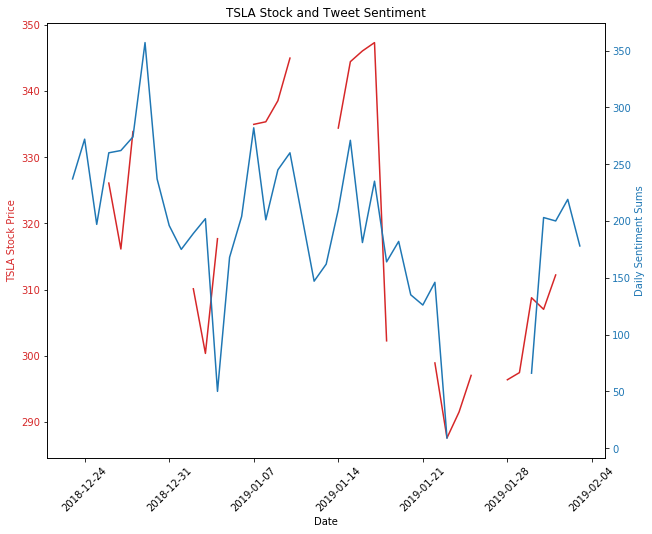

In [21]:
%matplotlib inline
x = dfMerged['Date']

x = [datetime.strptime(str(i), '%Y-%m-%d') for i in x]
y1 = dfMerged['Stock Price']
y2 = dfMerged['Sentiment Sums']

fig, ax1 = plt.subplots(figsize=(10, 8))

color = 'tab:red'
ax1.set_xlabel('Date')
ax1.set_ylabel('TSLA Stock Price', color=color)
ax1.plot(x, y1, color=color)
ax1.tick_params(axis='y', labelcolor=color)

ax2 = ax1.twinx()  # instantiate a second axes that shares the same x-axis
color = 'tab:blue'
ax2.set_ylabel('Daily Sentiment Sums', color=color)  # we already handled the x-label with ax1
ax2.plot(x, y2, color=color)
ax2.tick_params(axis='y', labelcolor=color)
for tick in ax1.get_xticklabels():
    tick.set_rotation(45)
plt.title("TSLA Stock and Tweet Sentiment")
fig.savefig("aaafig.pdf")